# Binaural Sonification of Magnetometer Data
The purpose of this notebook is to generate binaural audio displays of data from ground magnetometers and THEMIS satellites. 

### Import packages:

In [1]:
# Importing packages
import pandas as pd
smag = __import__('supermag-api')          # SuperMAG python API
logon = 'kd8oxt'                              # SuperMAG ID

import plotly.express as px                # for mapping, mainly
import plotly.graph_objects as go          # for mapping, mainly

import matplotlib.pyplot as plt
import numpy as np

# import os
# # os.environ["CDF_LIB"] = library_directory
# # os.environ["CDF_LIB"] = "~/CDF/lib"          # default "~/CDF/lib"
# from spacepy import pycdf                  # for reading CDF files

# For pulling data from CDAweb:
from ai import cdas
import datetime
from matplotlib import pyplot as plt

# for progress viz:
from tqdm .auto import tqdm
# from tqdm import tqdm_notebook as tqdm
# from tqdm.notebook import trange, tqdm
from IPython.display import clear_output     # Used as a workaround to make tqdm not do silly things

import pickle

from collections import Counter   # for listing unique values

# from hamsci_psws import goes

from scipy import signal

import os

# Import functions:

from magFunctions import *
import matplotlib.dates as mdates

import IPython # for playing sounds in the notebook

Install the `magSonify` package.

In [2]:
pip install git+https://github.com/marek-cottingham/magSonify/

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/marek-cottingham/magSonify/ to /tmp/pip-req-build-c5yese0w
  Running command git clone --filter=blob:none --quiet https://github.com/marek-cottingham/magSonify/ /tmp/pip-req-build-c5yese0w
  Resolved https://github.com/marek-cottingham/magSonify/ to commit 74edf69e6a89365d9a08935d58332bfcd8cfedc1
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


## Set parameters
First, we should establish the datetime range, stations, and cadence of the data that we want to examine with this approach. 

In [3]:
start = datetime.datetime(2016, 1, 25, 0, 0, 0) 
end = datetime.datetime(2016, 1, 25, 23, 0, 0)

Ground stations:

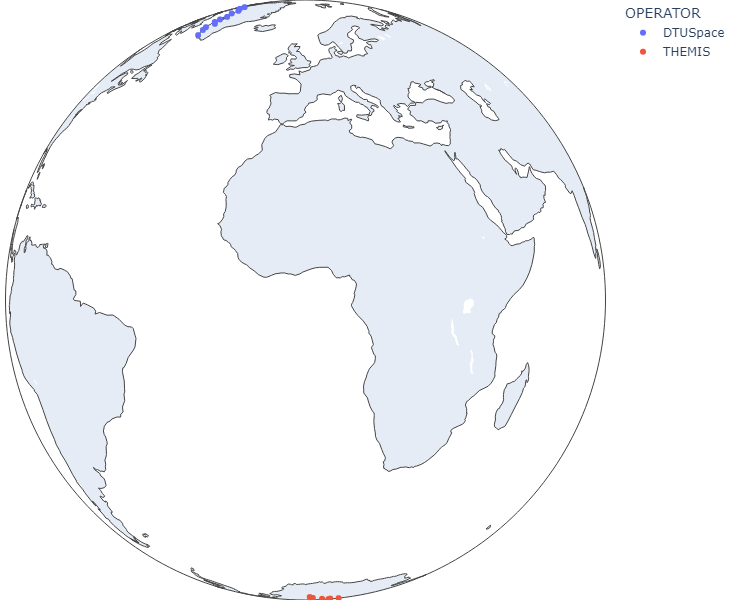

In [4]:
# Fetch station info from .csv and plot on a nice spinnable globe.
conjugate_stations = pd.read_csv('conjugate_stations.csv') # TODO: FIX THIS FILE!
conjugate_stations.Code

stations = pd.read_csv('20220726-04-17-supermag-stations.csv', sep = ',')   # edited version of this spreadsheet
stations = stations[stations.IAGA.isin(conjugate_stations.Code)] # Plot only the polar stations

# Plot stations:

fig = px.scatter_geo(stations, 
                     lat = stations.GEOLAT,
                     lon = stations.GEOLON,
                     color="OPERATOR", # size of markers, "pop" is one of the columns of gapminder
                     hover_name = "STATION-NAME", 
                     # text = "IAGA"
                     )
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


## Pull data of interest
Next, we pull the data of interest into pandas dataframes. 

## Sonify data
There are two pieces of information we need to sort out in this step: what each sound source sounds like, and where it is.

In [5]:
# import context
# context.get()

from datetime import datetime
from magSonify.MagnetometerData import THEMISdata
from magSonify.Utilities import ensureFolder
import numpy as np

outputDir = "Audio_Processing_Example"

ensureFolder(outputDir)

mag = THEMISdata()

event2007_09_04 = (datetime(2007,9,4), datetime(2007,9,5))
event2008_12_07 = (datetime(2008,12,7), datetime(2008,12,10))
event2011_09_02 = (datetime(2011, 9, 2), datetime(2011, 9, 6))

# Import the satellite data, specifying which themis satellite to use
mag.importCDAS(
    *event2008_12_07,
    satellite='D'
)

# Interpolate the data to a consistent, know spacing (also cleans the data to remove duplicates)
mag.interpolate(spacingInSeconds=3)

mag.magneticField.constrainAbsoluteValue(400)

# Compute the mean field, this is both to allow the mean field to be subtracted and for use later
# in .convertToMeanFieldCoordinates(). Note that the exact attribute name: .meanField must be 
# preserved in order for .convertToMeanFieldCoordinates() to work.
mag.meanField = mag.magneticField.runningAverage(timeWindow=np.timedelta64(35,"m"))
mag.magneticField = mag.magneticField - mag.meanField

mag.fillLessThanRadius(4)
mag.removeMagnetosheath()
mag.convertToMeanFieldCoordinates()

mag.magneticFieldMeanFieldCoordinates.fillNaN()

# Extract each of the field components as a 1D data set, perform the time stretch and output as
# audio
com = mag.magneticFieldMeanFieldCoordinates.extractKey(0)
com.phaseVocoderStretch(16)
com.normalise()
com.genMonoAudio(f"{outputDir}/Example of com x16 with phase vocoder.wav")

pol = mag.magneticFieldMeanFieldCoordinates.extractKey(1)
pol.phaseVocoderStretch(16)
pol.normalise()
pol.genMonoAudio(f"{outputDir}/Example of pol x16 with phase vocoder.wav")

tor = mag.magneticFieldMeanFieldCoordinates.extractKey(2)
tor.phaseVocoderStretch(16)
tor.normalise()
tor.genMonoAudio(f"{outputDir}/Example of tor x16 with phase vocoder.wav")

# Disable the wavelet stretch output if it's taking too long
# exit()

com = mag.magneticFieldMeanFieldCoordinates.extractKey(0)
com.waveletStretch(16,0.5,16)
com.normalise()
com.genMonoAudio(f"{outputDir}/Example of com x16 with wavelets.wav",sampleRate=44100//2)

pol = mag.magneticFieldMeanFieldCoordinates.extractKey(1)
pol.waveletStretch(16,0.5,16)
pol.normalise()
pol.genMonoAudio(f"{outputDir}/Example of pol x16 with wavelets.wav",sampleRate=44100//2)

tor = mag.magneticFieldMeanFieldCoordinates.extractKey(2)
tor.waveletStretch(16,0.5,16)
tor.normalise()
tor.genMonoAudio(f"{outputDir}/Example of tor x16 with wavelets.wav",sampleRate=44100//2)

In [6]:
# import IPython
IPython.display.Audio(outputDir + "/" +"Example of pol x16 with phase vocoder.wav")

### Convert data to sound
Now we sonify the data in the dataframes above using best practices for Pc5 waves. We'll be using the systems established in this paper: https://doi.org/10.3389/fspas.2022.877172 

The output of this code will be another pandas dataframe. 

### Convert station coordinates to spatial coordinates in audio environment
There are multiple ways that we can do this. One way is to put the listener at the center of the Earth and situate the stations around them. 

However we set it up, there are two things we should ensure:
- The audio coordinates should be a direct transform from the physical coordinates of the stations;
- The audio coordinates for satellites should be produced as pandas dataframes, so that they move over time.

## Binauralize audio
Next, we'll use spaudiopy (https://github.com/chris-hld/spaudiopy) to put the audio we computed at the coordinates we computed, and produce an audio file for it.